### 1. Import Libraries and data

In [7]:
# Useful imports
import pandas as pd
import numpy as np
from copy import copy
import matplotlib.pyplot as plt
import seaborn as sns

# Import ML-Classifiers
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# Import ML-preprocessing
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, fbeta_score
from sklearn.metrics import recall_score,precision_score,f1_score
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.utils import resample
from sklearn.metrics import roc_curve
import time
import warnings
warnings.filterwarnings("ignore")

In [8]:
df = pd.read_csv('02_dataset/home_credit_dataset_processed.csv', low_memory = True, index_col = 0)

### 2. Train-Test split

We need to split the training data into training and testing data for developing models. Also from the previous data exploration, we know that the target distribution in the training data is highly imbalanced. Thus, in order to give already an outlook for further work, the group will make use of SMOTE in the next ML-tasks to handle the imbalanced dataset. For now, we will stick with the traditional method of train-test split to evaluate models.

In [9]:
X = df.drop(['TARGET'], axis=1)
y = df[['TARGET']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 2021)

### 3. Model Fitting

Before fitting the best model, one needs to decide which algorithms to concider. As a result, we run a couple of standard models and performed a cross validation against the training set. From this we can determine what the benchmark accuracy metrics are for a variety of models. This can help us narrow down which models are performing well on the data.

#### 3.1. Algorithm comparison

According to Stackoverflow: when you have a data imbalance between positive and negative samples, you should always use F1-score because ROC averages over all possible thresholds! Thus, for the first comparision, we decided to use the recall-metric as the scoring metric, to decide, which of the chosen algorithms performes best on our dataset (https://stackoverflow.com/questions/44172162/f1-score-vs-roc-auc).<br>
<br>
Note: Since CatBoost, LGBM, MLP, SVM and KNN took a long time to run, we only focused for now on the other algorithms. For the next steps however, the group will also run other algos and test their performance.

Please wait while models train..
LR--> recall: 0.010365148896744253   (Training Time: 1.3891516208648682 mins)
LDA--> recall: 0.022086440668876616   (Training Time: 1.112919823328654 mins)
NB--> recall: 0.561884133877875   (Training Time: 0.10215845108032226 mins)
CART--> recall: 0.16329663174599512   (Training Time: 2.0528945763905844 mins)
RF--> recall: 0.002406462176337693   (Training Time: 16.593070562680563 mins)


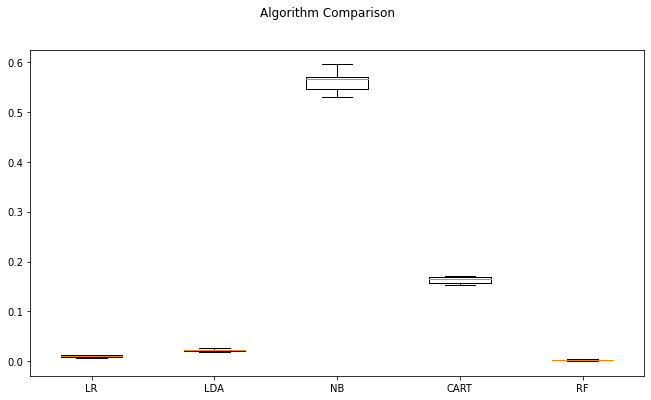

In [11]:
# Taken from: https://pythondata.com/comparing-machine-learning-methods/
num_folds = 10
seed = 2021
scoring = 'recall'
models = []

# Typical Classifiers
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('NB', GaussianNB()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('RF', RandomForestClassifier()))
#models.append(('CatBoost', CatBoostClassifier(logging_level='Silent', verbose=None)))
#models.append(('LGBM', LGBMClassifier()))
#models.append(('MLP', MLPClassifier()))
#models.append(('SVM', SVC(gamma='auto')))
#models.append(('KNN', KNeighborsClassifier()))



# iterate over models and print cross val scores
results = []
names = []
print('Please wait while models train..')
for name, model in models:
    
    # start timer
    start = time.time()
    
    # Cross Validation
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    
    # stop timing
    end = time.time()
    time_run = (end - start)/60
    output = "{}--> recall: {}   (Training Time: {} mins)".format(name, cv_results.mean(), time_run)
    
    print(output)

# boxplot algorithm comparison
fig = plt.figure(figsize=(11,6))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Almost all models show a very low "recall" scoring metric. We can observe that our best results was with Gaussian Naive Bayes. In the next step we will implement some other models like XGBoost, KNN, LGBM or SVM and try to do a simple tunning on them.

#### 3.2. Training Model and Test Predictions

As seen from the output above, GNB performed the best. However, since this classifier has no hyperparameters to tune, we will focus on others. Thus, we we'll try to performe a simple hyperparamter-tuning on LR and check the results based on the material covered so far in class. In the next steps, we will also do hyperparamter tuning on other (more suitable) classifiers.

In [4]:
# Taken from: https://towardsdatascience.com/logistic-regression-model-tuning-with-scikit-learn-part-1-425142e01af5
clf = LogisticRegression()
grid_values = {'penalty': ['l1', 'l2'],'C':[0.001,.009,0.01,.09,1,5,10,25]}
grid_clf_acc = GridSearchCV(clf, param_grid = grid_values,scoring = 'recall')
grid_clf_acc.fit(X_train, y_train)

print(grid_clf_acc.best_estimator_)

LogisticRegression(C=25, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [5]:
y_pred_acc = grid_clf_acc.predict(X_test)

print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred_acc)))
print('Precision Score : ' + str(precision_score(y_test,y_pred_acc)))
print('Recall Score : ' + str(recall_score(y_test,y_pred_acc)))
print('F1 Score : ' + str(f1_score(y_test,y_pred_acc)))

Accuracy Score : 0.9197758362781018
Precision Score : 0.4966887417218543
Recall Score : 0.010135135135135136
F1 Score : 0.019864918553833932


In [6]:
print('Confusion Matrix : \n' + str(confusion_matrix(y_test,y_pred_acc)))

Confusion Matrix : 
[[84778    76]
 [ 7325    75]]


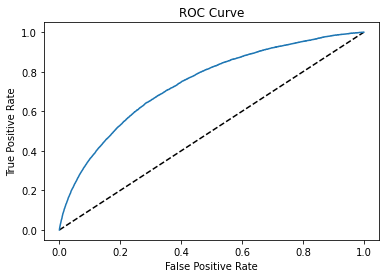

In [9]:
#Predicting proba
y_pred_prob = grid_clf_acc.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

### 4. Further project outlook

Given that our models have a very low recall score, the next steps will include the following:<br>
- Apply SMOTE to handle the class imbalance<br>
- Probably we will need to adjust the features again, try different feature selection (maybe just with PCA)<br>
- Try other classifiers<br>
- Apply a more in depth hyperparameter-tuning<br>
- Plot Learning Curves<br>
- Plot Reliability plot and Brier Score